# Speeches project

In [59]:
import re
import numpy as np
import pandas as pd
import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style='darkgrid')

# Text mining modules from Sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import metrics

# Modules from nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Modules from gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

analyser = SentimentIntensityAnalyzer()

lemmatizer = WordNetLemmatizer()

In [76]:
# Function for cleaning the text
def preprocess_text(text):

    # Removing special characters, punctuation, whitespaces and numbers
    text_clean = re.sub("[^a-zA-Z0-9 \n\.]", "", text)
    text_clean = re.sub(" +", " ", text_clean)
    text_clean = re.sub(r"[^\w\s]","", text_clean)
    text_clean = re.sub("\d", "", text_clean)

    # Changing the text into lowercase
    text_clean = text_clean.lower()

    # Applying tokenization to the text
    word_tokens = word_tokenize(text_clean)

    # Removing english stopwords
    stop_words = set(stopwords.words("english")) 
    word_tokens = [w for w in word_tokens if w not in stop_words]

    # Applying lemmatization to the tokens
    word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    text_clean = " ".join(word_tokens)

    return text_clean


# Function to plot SSE and Silhouette Score for a chosen range of k number of clusters
def get_clusters_number(data, max_k):

    sse = []
    sil = []
    k_range = range(2, max_k+1)

    for k in k_range:
        kfit = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans_model = kfit.fit(data)
        sse.append(kmeans_model.inertia_)
        sil.append(metrics.silhouette_score(data, kmeans_model.labels_, metric='euclidean'))

    fig, axs = plt.subplots(2, 1)
    axs[0].plot(k_range, sse, marker="o")
    axs[0].set_title("SSE for k number of clusters")
    axs[0].set(xlabel="k", ylabel="SSE", xticks=k_range)
    axs[1].plot(k_range, sil, marker="o")
    axs[1].set_title("Silhouette Score for k number of clusters")
    axs[1].set(xlabel="k", ylabel="Silhouette Score", xticks=k_range)
    fig.set_figheight(8)
    fig.set_figwidth(10)
    fig.tight_layout()
    plt.show()


# Function to plot the clusters
def plot_clusters(tfidf_vectors, clusters, num_k):

    # Computing the pca vectors for visualizing the clusters
    pca = PCA(n_components=2)
    pca_vectors = pca.fit_transform(tfidf_vectors.toarray())

    # Plotting the clusters
    plt.scatter(pca_vectors[:, 0], pca_vectors[:, 1], c=clusters, cmap='viridis')
    plt.title(f"Clustering results for k={num_k}")
    plt.xlabel(f"Principal Component 1 ({round(pca.explained_variance_[0]*100, 2)}%)")
    plt.ylabel(f"Principal Component 2 ({round(pca.explained_variance_[1]*100, 2)}%)")
    plt.show()


# Function to get the top n keywords for each cluster
def get_top_keywords(data, clusters, labels, n_terms):
    
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print(f'\nCluster {i}')
        # Sorting values in decreasing order and printing the first n terms
        print(', '.join([labels[t] for t in np.argsort(r)[::-1][:n_terms]]))


# Function for computing the coherence score
def compute_coherence_values(corpus, sent_speeches, sentim_id2word, k, a, b):
    lda_model = LdaModel(corpus=corpus,
                         id2word=sentim_id2word,
                         num_topics=k, 
                         random_state=42,
                         chunksize=len(corpus),
                         passes=10,
                         alpha=a,
                         eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sent_speeches, dictionary=sentim_id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()


# Function for computing the coherence score for different hyperparameter combinations
def topic_num_search(sent_corpus, sent_speeches, sentim_dict):
    grid = {}
    grid['Validation_Set'] = {} 

    min_topics = 2
    max_topics = 10
    step_size = 2
    topics_range = range(min_topics, max_topics, step_size)

    warnings.filterwarnings("ignore", category=DeprecationWarning) 

    corpus_sets = [sent_corpus]
    corpus_title = ['100% Corpus']

    alpha=['symmetric', 'asymmetric']
    beta=['symmetric']

    model_results = {'Validation_Set': [],
                    'Topics': [],
                    'Alpha': [],
                    'Beta': [],
                    'Coherence': []
                    }

    if 1 == 1:
        pbar = tqdm.tqdm(total=len(corpus_sets)*len(topics_range)*len(alpha)*len(beta))
        
        for i in range(len(corpus_sets)):
            for k in topics_range:
                for a in alpha:
                    for b in beta:
                        print(i, k, a, b)
                        
                        cv = compute_coherence_values(corpus=corpus_sets[i], sent_speeches=sent_speeches, sentim_id2word=sentim_dict,
                                                      k=k, a=a, b=b)
                        model_results['Validation_Set'].append(corpus_title[i])
                        model_results['Topics'].append(k)
                        model_results['Alpha'].append(a)
                        model_results['Beta'].append(b)
                        model_results['Coherence'].append(cv)
                        print({k: v[-1] for k, v in model_results.items()})

                        pbar.update(1)
        pbar.close()
        model_results=pd.DataFrame(model_results)
    
    return model_results


# Function for displaying top n words from each topic
def display_topics(lda_model, num_topics, no_top_words):
    topic_dict = {}
    for idx in range(num_topics):
        topic_dict[f"Topic {idx} words"]= [x[0] for x in lda_model.show_topic(idx, no_top_words)]

        topic_dict[f"Topic {idx} weights"]= [round(x[1], 4) for x in lda_model.show_topic(idx, no_top_words)]
    return pd.DataFrame(topic_dict)

Available columns include the translated title, date of the speech, translated text, date of the major event the speech was connected to, details of that event and an indicator if the speech took place before or after the event.

In [61]:
# Loading the speeches of Turkey's president
speeches_df = pd.read_csv("Erdogan_translated_speeches.csv")
speeches_df.head()

,Translated_title,Date,Translated_text,Event_date,Detail,When
0,Their Speech at the Inauguration Ceremony,2023-06-03,"\n\nDear Nation, Dear Heads of State and Gover...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
1,Their Speech at the Social Complex After the E...,2023-05-28,\n\nWe love Turkey very much. Isn't this natio...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
2,"Strong Industry, Strong Türkiye Speech at the ...",2023-05-25,"\n\nDear Industrialists,\nDear Brothers and Si...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
3,Their Speech at the Keçiören NGO Representativ...,2023-05-24,"\n\nDear Ankara residents,\nDear Beautiful Peo...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
4,Their Speech at the Great Rumelia Meeting,2023-05-22,"\n\nOur Dear Youth,\nDear Ladies and Sisters,\...",2023-05-28,Recep Tayyip Erdoğan won the election between ...,before


Dataset does not include any missing values.

In [62]:
# Checking for NAs
speeches_df.isna().sum()

Translated_title    0
Date                0
Translated_text     0
Event_date          0
Detail              0
When                0
dtype: int64

The text is cleaned for further analysis.

In [63]:
text_df_clean = speeches_df.copy()
text_df_clean["Translated_text"] = text_df_clean.Translated_text.map(preprocess_text)
text_df_clean.head()

,Translated_title,Date,Translated_text,Event_date,Detail,When
0,Their Speech at the Inauguration Ceremony,2023-06-03,dear nation dear head state government dear pa...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
1,Their Speech at the Social Complex After the E...,2023-05-28,love turkey much isnt nation loved love qandil...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,after
2,"Strong Industry, Strong Türkiye Speech at the ...",2023-05-25,dear industrialist dear brother sister greet h...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
3,Their Speech at the Keçiören NGO Representativ...,2023-05-24,dear ankara resident dear beautiful people kei...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before
4,Their Speech at the Great Rumelia Meeting,2023-05-22,dear youth dear lady sister dear citizen greet...,2023-05-28,Recep Tayyip Erdoğan won the election between ...,before


## Text clustering

Every speech is represented as a TF-IDF vector, with the inclusion of bigrams and exclusion of terms that appear in less than 5% of all speeches.

In [64]:
tfidf_text_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=0.05)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(text_df_clean.Translated_text)

Using the elbow method on the Sum of Square Error plot, it was decided that the speeches fall into one of seven clusters.

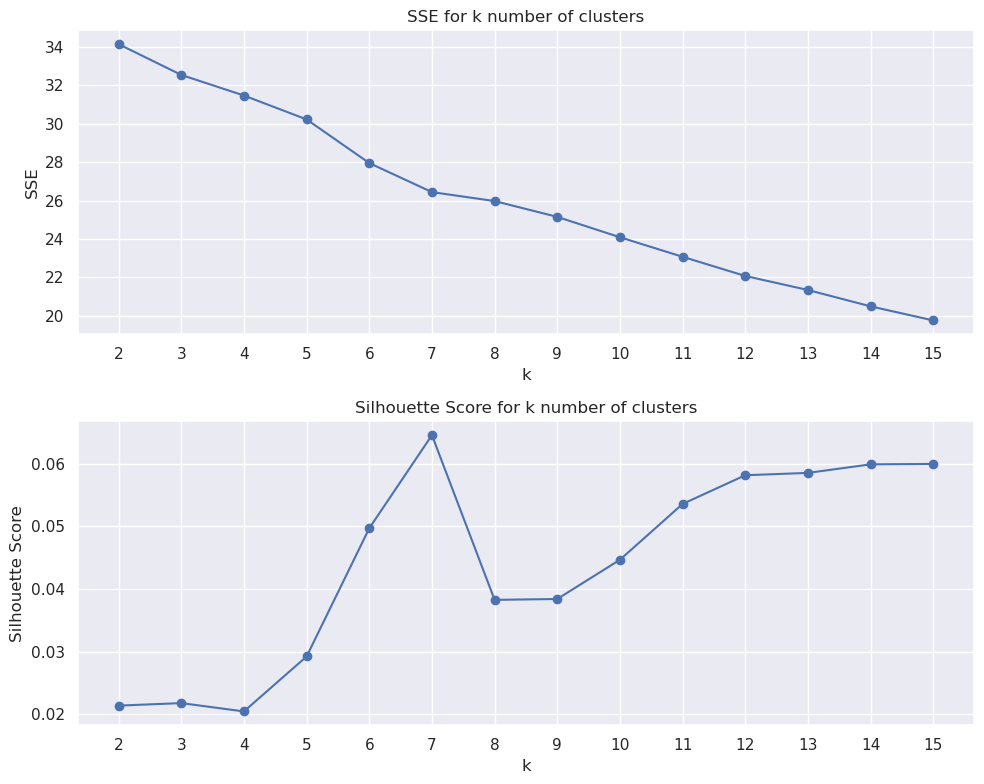

In [65]:
get_clusters_number(tfidf_text_vectors, 15)

Now, the determined number of clusters will be used to apply K-means algorithm on the data. Plotting may not be ideal here, since the explained variance of two principal components is not very high.

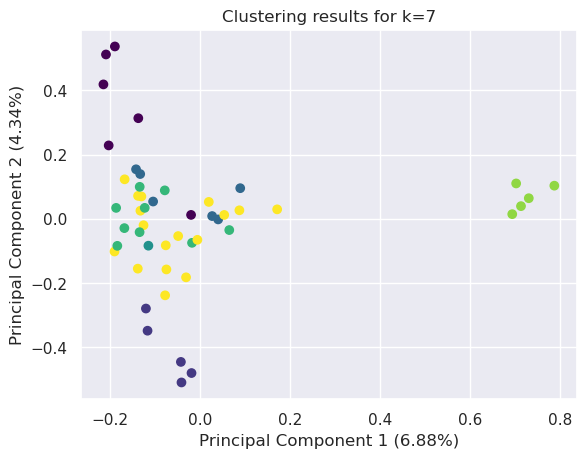

In [66]:
text_k = 7
kfit = KMeans(n_clusters=text_k, n_init='auto', random_state=42)
clusters = kfit.fit_predict(tfidf_text_vectors)
plot_clusters(tfidf_text_vectors, clusters, text_k)

To get a better grasp of what each cluster refers to, 15 top keywords are printed.

In [67]:
get_top_keywords(tfidf_text_vectors, clusters, tfidf_text_vectorizer.get_feature_names_out(), 15)


Cluster 0
istanbul, brother, conquest, binali, say, know, chp, nation, candidate, people, one, yldrm, mayor, metropolitan, binali yldrm

Cluster 1
nation, coup, july, coup attempt, attempt, country, one, turkey, state, armed, terrorist, force, organization, democracy, tank

Cluster 2
nation, country, konya, people, teknofest, brother, turkey, one, say, mr kemal, chp, kemal, young, space, year

Cluster 3
system, country, presidential system, nation, say, yes, presidential, executive, one, military service, governed, management, new system, constitutional amendment, amendment

Cluster 4
nation, brother, country, say, people, turkey, know, headman, mosque, one, siva, said, come, van, rize

Cluster 5
earthquake, aid, disaster, thousand, rescue, search rescue, earthquake zone, search, zone, province, region, team, destruction, citizen, country

Cluster 6
nation, country, turkey, election, party, one, people, like, would, brother, year, ak party, every, ak, dear


## Sentiment Analysis and topic modeling

Next step of the analysis involves inspecting what topics are present in speech paragraphs with positive and negative sentiment. Paragraphs were determined to be more suitable for this task than whole text of speech, because it was very possible that the overall sentiment would be positive, since politicians try to appeal to the public. By dividing each speech into paragraphs, it is possible to see what issues the president is speaking about negatively.

The sentiment is obtained with VADER.

In [68]:
par_list = [par for speech in speeches_df["Translated_text"].map(lambda x: x.split("\n")) for par in speech if par != ""]
par_df = pd.DataFrame(par_list, columns=["Paragraph"])
par_df["Sentiment"] = par_df.Paragraph.map(analyser.polarity_scores)
par_df["Sentiment"] = par_df["Sentiment"].map(lambda x: x["compound"])

Threshold values from the literature (https://github.com/cjhutto/vaderSentiment) suggest that a compound score below -0.05 relates to negative pieces of text.

In [69]:
par_df["Sentiment"] = par_df["Sentiment"].map(lambda x: "positive" if x>=0.05 else ("neutral" if x>-0.05 else "negative"))

A clear majority of paragraphs contain positive language.

In [70]:
par_df.groupby("Sentiment").count()

,Paragraph
Sentiment,
negative,845
neutral,582
positive,2247


It is necessary to preprocess text as was done before.

In [71]:
par_df.Paragraph = par_df.Paragraph.map(lambda x: preprocess_text(x))
par_df.head()

,Paragraph,Sentiment
0,dear nation dear head state government,positive
1,dear parliament speaker,positive
2,vice president,neutral
3,dear country representative dear friend home a...,positive
4,lady gentleman,neutral


In [72]:
pos_df = par_df.loc[par_df.Sentiment == "positive"].reset_index(drop=True)
neg_df = par_df.loc[par_df.Sentiment == "negative"].reset_index(drop=True)

In [73]:
pos_speeches = [x.split() for x in pos_df["Paragraph"]]
pos_dictionary = Dictionary(pos_speeches)
pos_corpus = [pos_dictionary.doc2bow(speech) for speech in pos_speeches]

neg_speeches = [x.split() for x in neg_df["Paragraph"]]
neg_dictionary = Dictionary(neg_speeches)
neg_corpus = [neg_dictionary.doc2bow(speech) for speech in neg_speeches]

In [77]:
pos_model_results = topic_num_search(pos_corpus, pos_speeches, pos_dictionary)
neg_model_results = topic_num_search(neg_corpus, neg_speeches, neg_dictionary)

0 2 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.4928529807986184}
0 2 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.5126572270283313}
0 4 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.4805169867479824}
0 4 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.48616814435066547}
0 6 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.49380683253034213}
0 6 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.5228319599515686}
0 8 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.5205118275415869}
0 8 asymmetric symmetric


100%|██████████| 8/8 [02:45<00:00, 20.75s/it]


{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.5305536765010723}


0 2 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.4452479453068089}
0 2 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 2, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.49853754686115}
0 4 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.4503081032344251}
0 4 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 4, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.4212363493895237}
0 6 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.41587786461465703}
0 6 asymmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 6, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.4015536512168816}
0 8 symmetric symmetric


{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'symmetric', 'Beta': 'symmetric', 'Coherence': 0.40771411953528575}
0 8 asymmetric symmetric


100%|██████████| 8/8 [00:52<00:00,  6.62s/it]

{'Validation_Set': '100% Corpus', 'Topics': 8, 'Alpha': 'asymmetric', 'Beta': 'symmetric', 'Coherence': 0.41884843060686194}


Coherence score is a measure used for determining the interpretability of LDA topics to humans. Naturally, it can be used for optimizing the number of topics.

For positive paragraphs 8 or 6 topics are deemed most appropriate and for negative ones 2 or 4 topics.

In [78]:
pos_model_results.sort_values('Coherence', ascending = False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
7,100% Corpus,8,asymmetric,symmetric,0.530554
5,100% Corpus,6,asymmetric,symmetric,0.522832
6,100% Corpus,8,symmetric,symmetric,0.520512
1,100% Corpus,2,asymmetric,symmetric,0.512657
4,100% Corpus,6,symmetric,symmetric,0.493807


In [79]:
neg_model_results.sort_values('Coherence', ascending = False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
1,100% Corpus,2,asymmetric,symmetric,0.498538
2,100% Corpus,4,symmetric,symmetric,0.450308
0,100% Corpus,2,symmetric,symmetric,0.445248
3,100% Corpus,4,asymmetric,symmetric,0.421236
7,100% Corpus,8,asymmetric,symmetric,0.418848


In [80]:
# Creating LDA models with the hyperparameters chosen according to the highest coherence score
passes=10

# LDA model for positive tweets
pos_lda_model = LdaModel(
    corpus=pos_corpus,
    id2word=pos_dictionary,
    chunksize=len(pos_corpus),
    alpha='asymmetric',
    eta='symmetric',
    random_state=42,
    num_topics=8,
    passes=passes,
    per_word_topics=True
)

# LDA model for negative tweets
neg_lda_model = LdaModel(
    corpus=neg_corpus,
    id2word=neg_dictionary,
    chunksize=len(neg_corpus),
    alpha='asymmetric',
    eta='symmetric',
    random_state=42,
    num_topics=4,
    passes=passes,
    per_word_topics=True
)

In [81]:
display_topics(pos_lda_model, 8, 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights
0,dear,0.0243,nation,0.0197,turkey,0.0115,say,0.0127,nation,0.0209,work,0.0140,thousand,0.0254,istanbul,0.0102
1,brother,0.0217,one,0.0118,istanbul,0.0103,know,0.0088,people,0.0129,country,0.0120,billion,0.0139,country,0.0081
2,nation,0.0179,country,0.0084,know,0.0096,brother,0.0078,country,0.0116,turkey,0.0111,lira,0.0130,nation,0.0078
3,like,0.0169,people,0.0083,airport,0.0091,like,0.0074,turkey,0.0072,say,0.0110,million,0.0123,party,0.0076
4,would,0.0150,u,0.0078,year,0.0088,party,0.0071,party,0.0071,said,0.0088,year,0.0091,year,0.0066
5,sister,0.0141,election,0.0078,new,0.0081,said,0.0071,election,0.0061,nation,0.0083,dollar,0.0087,also,0.0062
6,u,0.0119,party,0.0074,water,0.0080,country,0.0070,day,0.0058,u,0.0075,country,0.0087,u,0.0059
7,god,0.0115,turkey,0.0071,built,0.0074,bridge,0.0066,one,0.0053,year,0.0073,number,0.0071,hopefully,0.0056
8,thank,0.0093,know,0.0067,say,0.0072,would,0.0064,every,0.0046,god,0.0070,support,0.0064,service,0.0054
9,country,0.0090,say,0.0067,party,0.0072,look,0.0062,year,0.0043,continue,0.0068,turkey,0.0060,know,0.0052


In [82]:
display_topics(neg_lda_model, 4, 10)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights
0,nation,0.0187,country,0.0112,earthquake,0.0094,one,0.0056
1,terrorist,0.0134,say,0.0064,nation,0.0089,country,0.0051
2,country,0.0129,also,0.0061,u,0.0085,problem,0.0051
3,organization,0.0111,state,0.0055,country,0.0084,vote,0.0048
4,say,0.0096,one,0.0054,thousand,0.0079,earthquake,0.0048
5,people,0.0084,world,0.0052,turkey,0.0058,blood,0.0046
6,u,0.0076,turkey,0.0052,disaster,0.0057,municipality,0.0044
7,one,0.0070,chp,0.0049,people,0.0057,know,0.0043
8,know,0.0068,problem,0.0048,know,0.0055,first,0.0042
9,state,0.0067,people,0.0042,work,0.0053,citizen,0.0039
